# Linear regression runthrough
#### by Alvin Zhang
##### Notes and examples based on Bishop's "Pattern Recognition and Machine Learning"

<b>Linear model</b>: $y(\vec{x},\vec{w})=w_0+\sum_{j=1}^{M-1}w_j\phi_j(\vec{x})=\vec{w}^T\vec{\phi}(\vec{x})$

## Maximum likelihood

Suppose we have 100 points of random sinusoidal data with Gaussian noise of variance $0.03^2$.
i.e., $$t=\sin(1+x^2)+\epsilon$$
where $\epsilon=\mathcal{N}(x|0,0.03^2)$.

In [1]:
import numpy as np


def gen_sin(N=100, s=.03):
    """
    Generate random sinusoidal data.
    Args:
        N (int): number of samples to generate
        s (float): variance of noise
    Returns:
        X (float ndarray): randomly generated x values
        t (float ndarray): sinusoidal target values with Gaussian noise
    """
    X = np.random.rand(N, 1)
    noise = s * np.random.randn(N, 1)
    t = np.sin(1 + X**2) + noise
    return X, t


Plot of data:

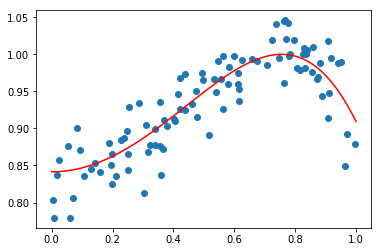

In [82]:
import matplotlib.pyplot as plt


def plot_sin_data(fig, X=None, t=None):
    """
    Plots sinusoidal data.
    Args:
        fig (figure): figure to plot on
        X (float ndarray): x values to plot
        t (float ndarray): target values to plot
    """
    # Plot points
    if X is not None and t is not None: fig.plot(X, t, 'o')
    # Plot curve
    x_coords = np.arange(0, 1.01, .01)
    y_coords = np.sin(1 + x_coords ** 2)
    fig.plot(x_coords, y_coords, 'r-')

X, t = gen_sin()
plot_sin_data(plt, X, t)
plt.show()


Let's first try fitting a polynomial of degree 3 to this data set. This means $\phi_j(x)=x^j$ for $j=0,1,2,3$. The polynomial basis function is defined below.

In [114]:
def poly_basis(X, M):
    """
    Generates design matrix based off polynomial basis
    Args:
        X (float ndarray): dataset or data point
        M (int): number of basis functions/degree
    Returns:
        dm (float ndarray): design matrix
    """
    N = X.shape[0]
    dm = np.ones((N, M+1))
    for d in range(M+1):
        dm[:,[d]] = X**d
    return dm


Each row looks like: $$(1,x_0^1,x_0^2,x_0^3)$$
where $x_0$ is a data point. It will be convenient to construct a basis utility so we can readily access different bases. We've defined the polynomial and Gaussian bases (as well as a 'no basis' which just appends the bias terms) below.


In [41]:
import numpy as np


class BasisUtil:
    def __init__(self, basis_name='polynomial', **kwargs):
        """
        Initializes basis utility.
        Args:
            basis_name (string): either 'gaussian', 'polynomial', or 'none'
            **kwargs: parameters for kernels
        """
        self.basis_name = basis_name
        self.parameters = kwargs

    def dm(self, X):
        """
        Constructs design matrix.
        Args:
            X (float ndarray): dataset or data point
        Returns:
            dm (float ndarray): design matrix
        """
        # Default parameters
        self.parameters.setdefault('M', 3)
        self.parameters.setdefault('m', np.arange(0, 1.01, .1))
        self.parameters.setdefault('s', .1)
        if self.basis_name == 'polynomial':
            def poly_basis(X, M):
                """
                Generates design matrix based off polynomial basis
                Args:
                    X (float ndarray): dataset or data point
                    M (int): number of basis functions/degree
                Returns:
                    dm (float ndarray): design matrix
                """
                N = X.shape[0]
                dm = np.ones((N, M+1))
                for d in range(M+1):
                    dm[:, [d]] = X**d
                return dm
            return poly_basis(X, self.parameters['M'])
        if self.basis_name == 'gaussian':
            def gaussian_basis(X, m, s):
                """
                Generates design matrix based off Gaussian basis
                Args:
                    X (float ndarray): dataset or data point
                    m (float ndarray): means
                    s (float): variance
                Returns:
                    dm (float ndarray): design matrix
                """
                N = X.shape[0]
                M = len(m) + 1
                dm = np.ones((N, M))
                for i in range(1, M):
                    dm[:, [i]] = np.exp(-(X-m[i-1])**2/(2*s**2))
                return dm
            return gaussian_basis(X, self.parameters['m'], self.parameters['s'])
        if self.basis_name == 'none':
            def no_basis(X):
                """
                Generates design matrix with no basis
                Args:
                    X (float ndarray): dataset or data point
                Returns:
                    dm (float ndarray): design matrix
                """
                N = X.shape[0]
                dm = np.hstack((np.ones((N, 1)), X))
                return dm
            return no_basis(X)
        raise ValueError('invalid kernel name')


We proceed with the normal equation, which is found by setting the likelihood function's derivative to zero (w.r.t. $\vec{w}$). <br>
Recall that given input $\mathbf{X}=\{\vec{x}_1,...,\vec{x}_N\}$ with corresponding $\vec{t}=\{t_1,...,t_N\}$, the likelihood function is $$p(\vec{t}|\mathbf{X},\vec{w},\beta)=\prod_{n=1}^N\mathcal{N}(t_n|\vec{w}^T\vec{\phi}^T,\beta^{-1})$$
After differentiating the log likelihood w.r.t. $\vec{w}$, the critical point is given by $$\vec{w}_{ML}=(\Phi^T\Phi)^{-1}\Phi^T\vec{t}$$
where
$$\Phi = \begin{bmatrix} 
    \phi_0(\vec{x}_1) & \dots & \phi_{M-1}(\vec{x}_1) \\
    \vdots & \ddots & \vdots \\
    \phi_0(\vec{x}_n) &  \dots    & \phi_{M-1}(\vec{x}_n)
    \end{bmatrix}
$$
$\Phi$ is known as the <i>design matrix</i>. These are the normal equations for least squares, and it gives the direct solution for maximum likelihood. <br>
We can also find a maximum likelihood estimation of $\beta^{-1}$, the variance. If we find the critical point of the log likelihood w.r.t. $\beta$, we find that $$\frac{1}{\beta_{ML}}=\frac{1}{N}\sum_{n=1}^N(t_n-\vec{w}^T_{ML}\vec{\phi}(\vec{x}_n))^2$$
In the code below, we've constructed a maximum likelihood estimator object that has two primary functions: fit and predict.

In [75]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mv_gauss
from scipy.stats import norm as sv_gauss


class MLE:
    def __init__(self, X, t, basis_name='polynomial', **kwargs):
        """
        Initializes maximum likelihood estimator object.
        Args:
            X (float ndarray): training data inputs
            t (float ndarray): training data targets
            basis_name (string): name of basis used
            **kwargs: basis function parameters
        Returns:
            w_ml (float ndarray): maximum likelihood weights 
        """
        self.basis_util = BasisUtil(basis_name, **kwargs)
        self.dm = self.basis_util.dm(X)
        self.N, self.M = self.dm.shape
        self.t = t
        self.w_ml = None
        self.var_ml = None

    def _norm_eq(self, lam):
        """
        Maximum likelihood solution via normal equations.
        Args:
            lam (float ndarray): regularization coefficient
        """
        self.w_ml = np.linalg.inv(lam * np.identity(self.M) +
                                  self.dm.T.dot(self.dm)).dot(self.dm.T).dot(self.t)
        self.var_ml = 1/self.N * np.sum((self.t-self.dm.dot(self.w_ml))**2)

    def _gd(self, lam, lp):
        """
        Gradient descent.
        Args:
            lam (float ndarray): regularization coefficient
            lp (float): learning parameter
        """
        self.w_ml = np.random.rand(self.M, 1)
        for n in range(self.N):
            self.w_ml -= lp\
                         * (self.w_ml.T.dot(self.dm[[n],:].T) - self.t[n])\
                         * self.dm[[n], :].T
            self.w_ml[1:] -= lam * self.w_ml[1:]
        self.var_ml = 1/self.N * np.sum((self.t-self.dm.dot(self.w_ml))**2)

    def fit(self, lam=0, lp=0.3, method='normal'):
        """
        Fits maximum likelihood solution based on data.
        Args:
            lam (float ndarray): regularization coefficient
            lp (float): learning parameter
            method (string): normal (normal equations) or gd (gradient descent)
        Returns:
            w_ml (float ndarray): maximum likelihood weights 
        """
        if method == 'normal':
            self._norm_eq(lam)
            return self.w_ml
        if method == 'gd':
            self._gd(lam, lp)
            return self.w_ml
        raise ValueError('invalid method name')

    def pred(self, x):
        """
        Predicts target based on an input.
        Args:
            x (float ndarray): single or multiple inputs (row vector)
        Returns:
            (float ndarray): predicted values 
        """
        assert self.w_ml is not None, 'Need to fit first.'
        phi = self.basis_util.dm(x)
        return phi.dot(self.w_ml)


In [80]:
reg = MLE(X, t, basis_name='polynomial', M=3)
reg.fit(method='normal')
reg.w_ml, reg.var_ml

(array([[ 0.86144598],
        [-0.32894783],
        [ 1.81714792],
        [-1.4719732 ]]), 0.00086870688271035459)

This is close to the real variance, $.03^2=.0009$. Note that MLE typically underestimates variance. <br>
With these two parameters, we get a predictive distribution $p(t|x)=\mathcal{N}(t|y(x,\vec{w}_{ML}),\beta^{-1}_{ML})$.

The plot with the maximum likelihood weights are shown below in green, along with the true function in red:

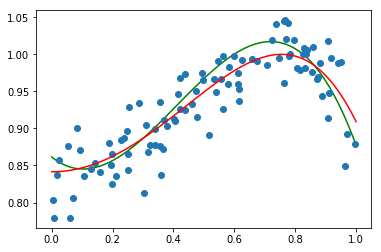

In [84]:
x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt, X, t)
plt.show()

### Gradient descent

Suppose we have an enormous dataset, and data is comes in a continuous stream. Stochastic gradient descent gives us an <i>online learning </i> scheme.

In [33]:
X, t = gen_sin(1000000)

Instead of using normal equations every time new data comes in, we can try a sequential approach with by slightly adjusting the weight parameters with each new data point. This is given by $$\vec{w}^{(\tau+1)}=\vec{w}^{(w)}-\eta\nabla E_n$$
where $\tau$ denotes the iteration number, $\eta$ is the learning parameter, and $E$ is the error for a data point. For sum-of-squares error, this is
$$\vec{w}^{(\tau+1)}=\vec{w}^{(w)}-\eta(\vec{w}^{(\tau)^T}\phi_n-t_n)\phi_n$$
where $\phi_n=\phi_n(\vec{x}_n)$. We've already implemented gradient descent as an optimization technique in the MLE object defined above.

In [34]:
reg = MLE(X, t, basis_name='polynomial', M=3)
reg.fit(method='gd')
reg.w_ml, reg.var_ml

(array([[ 0.84735561],
        [-0.13903044],
        [ 1.2313406 ],
        [-1.00636032]]), 0.0010051425107126604)

The plot with weights achived by stochastic gradient descent is shown below in green:

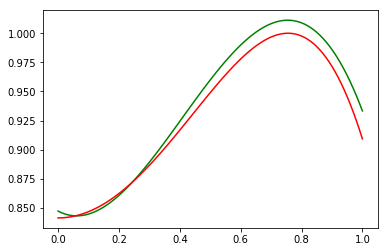

In [35]:
x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt)
plt.show()

### Regularization

If we use a polynomial basis with a maximum degree of 9, the model will be prone to overfitting, as seen below:

In [42]:
X, t = gen_sin(25)

reg = MLE(X, t, basis_name='polynomial', M=9)
reg.fit(method='normal')
reg.w_ml

array([[  7.64385580e-01],
       [  5.55073156e+00],
       [ -1.05615949e+02],
       [  9.11980396e+02],
       [ -4.14900466e+03],
       [  1.09080821e+04],
       [ -1.71858354e+04],
       [  1.60327651e+04],
       [ -8.17327511e+03],
       [  1.75555485e+03]])

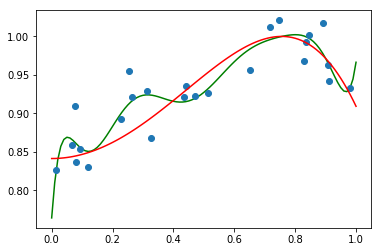

In [43]:
x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt, X, t)
plt.show()

Note that some of the coefficients in $w_{ML}$ are very large - this is an indicator that the function is too tuned to the data. If we take a look at the plot, the overfitting makes the curve look not smooth. In the plot above, we only use 100 data points. Overfitting would be less of a problem if we had an enormous amount of data. To address this problem, we turn to regularization. To limit the size of the coefficients, we add a quadratic regularizer so that
$$E(\vec{w})=\frac{1}{2}\sum_{n=1}^N(t_n-\vec{w}^T\vec{\phi}(\vec{x}_n))^2+\frac{\lambda}{2}\sum_{j=1}^M|w_j|^2$$
where $\lambda$ is the regularization coefficient. Other regularizers can be obtained by changing the power, but the quadratic regularizer keeps the degree of the error function at 2 so we can still find a closed form solution via the normal solution, which is given by 
$$\vec{w}=(\lambda\mathbf{I}+\Phi^T\Phi)^{-1}\Phi^T\vec{t}$$

In [44]:
reg = MLE(X, t, basis_name='polynomial', M=9)
reg.fit(method='normal', lam=0.3)
reg.w_ml

array([[ 0.82568725],
       [ 0.19283746],
       [ 0.05766667],
       [ 0.01337533],
       [-0.00722731],
       [-0.01935749],
       [-0.02731889],
       [-0.03267383],
       [-0.03619593],
       [-0.03837645]])

The plot using regularized weights for polynomial of degree 9 is shown below in green. Note that it is much smoother than the one shown above.

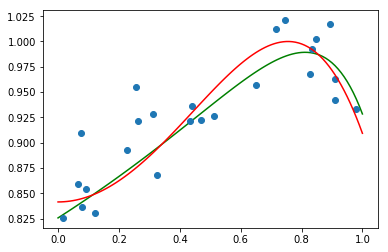

In [45]:
x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt, X, t)
plt.show()

Besides using a polynomial basis, we can try using a Gaussian basis, where each function is $\phi_j(x)=e^{-\frac{(x-\mu_j)^2}{2s^2}}$.

In [134]:
def gaussian_basis(X, m, s):
    '''
    Generates design matrix based off Gaussian basis
    Args:
        X (float ndarray): dataset or data point
        m (float ndarray): means
        s (float): variance
    Returns:
        dm (float ndarray): design matrix
    '''
    N = X.shape[0]
    M = len(m) + 1
    dm = np.ones((N, M))
    for i in range(1, M):
        dm[:,[i]] = np.exp(-(X-m[i-1])**2/(2*s**2))
    return dm

And here's the plot shown in green. The parameter `m` defines the means that the Gaussians are centered on, and `s` is the variance of each distribution.

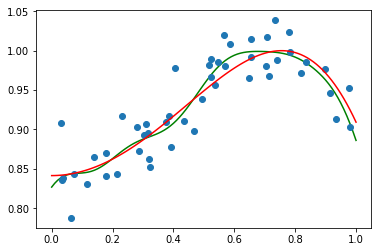

In [54]:
X, t = gen_sin(50)
m = np.arange(0, 1.01, .1)
s = .1

reg = MLE(X, t, basis_name='gaussian', m=m, s=s)
reg.fit(method='normal', lam=.1)

x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt, X, t)
plt.show()

Here's a more illustrative example, with plots of 10 datasets of 50 points each.

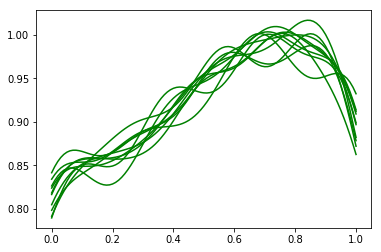

In [55]:
for _ in range(10):
    X, t = gen_sin(50)
    m = np.arange(0, 1.01, .1)
    s = .1
    reg = MLE(X, t, basis_name='gaussian', m=m, s=s)
    reg.fit(method='normal', lam=.1)
    x_coords = np.arange(0, 1.01, .01)
    y_coords = reg.pred(x_coords.reshape(-1, 1))
    plt.plot(x_coords, y_coords, 'g-')
plt.show()

## Maximum a posterori

We already know the likelihood function as $p(\vec{t}|\mathbf{X},\vec{w},\beta)=\prod_{n=1}^N\mathcal{N}(t_n|\vec{w}^T\vec{\phi},\beta^{-1})$. Assume that the noise $\beta^{-1}$ is a known constant. Suppose we want to introduce a prior $p(\vec{w})=\mathcal{N}(\vec{w}|\vec{w}_0,\mathbf{S}_0)$. Then the posterior is given by
$$p(\vec{w}|\vec{t})=\mathcal{N}(\vec{w}|\vec{m}_N,\mathbf{S}_N)$$
where $\vec{m}_N = \mathbf{S}_N(\mathbf{S}_0^{-1}\vec{m}_0+\beta\Phi^T\vec{t})$ and $\mathbf{S}_N^{-1}=\mathbf{S}_0^{-1}+\beta\Phi^T\Phi$. This is obtained using Bayes' theorem and comparing coefficients.<br>
To simplify, we asume an isotropic zero mean for the Gaussian (i.e. $p(\vec{w})=\mathcal{N}(\vec{w}|\vec{0},\alpha^{-1}\mathbf{I})$). <br>
Then the posterior can be simplified so that $\vec{m}_N=\beta\mathbf{S}_N\Phi^T\vec{t}$ and $\mathbf{S}_N^{-1}=\alpha\mathbf{I}+\beta\Phi^T\Phi$. The log posterior is given as $$\log{p(\vec{w}|\vec{t})}=-\frac{\beta}{2}\sum_{n=1}^N(t_n-\vec{w}^T\phi(\vec{x}_n))^2-\frac{\alpha}{2}\vec{w}^T\vec{w}+\text{const}$$
Notice that maximizing this quantity is the same as minimizing the sum-of-squares error with quadratic regularization with $\lambda=\frac{\alpha}{\beta}$. This is because the prior is centered at 0, so the weights are pulled towards it and therefore have a smaller magnitude.

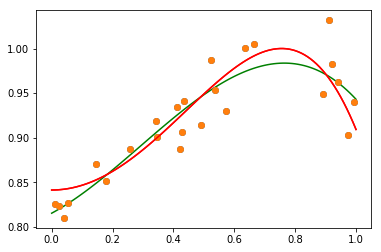

In [59]:
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mv_gauss


class MAP:
    def __init__(self, X, t, basis_name='polynomial',
                 alpha=1, beta=400, m_0=None, S_0=None, **kwargs):
        """
        Initializes MAP object.
        Args:
            dm (float ndarray): design matrix
            t (float ndarray): target values
            alpha (float): alpha value for prior
            beta (float): beta value in likelihood (noise)
            m_0 (float ndarray): prior mean
            S_0 (float ndarray): prior covariance
        """
        self.basis_util = BasisUtil(basis_name, **kwargs)
        self.dm = self.basis_util.dm(X)
        self.N, self.M = self.dm.shape
        self.t = t
        self.beta = beta
        # Prior
        self.alpha = alpha
        if m_0 is None:
            m_0, S_0 = self._default_prior()
        self.m_0 = m_0
        self.S_0 = S_0

        self.w_map = None
        self.gamma = None
        
    def _default_prior(self):
        """
        Generates a default prior.
        Returns:
            m_0 (float ndarray): default prior mean
            S_0 (float ndarray): default prior covariance
        """
        M = self.dm.shape[1]
        m_0 = np.zeros((M, 1))
        S_0 = 1/self.alpha * np.identity(M)
        return m_0, S_0

    def fit(self, maxiter=1000):
        """
        Finds MAP estimate.
        Returns:
            w_map (float ndarray): MAP estimate for weight parameter
        """
        def neg_log_posterior(w):
            return -self.posterior().logpdf(w.ravel())
        self.w_map = np.ones(self.M).reshape(-1, 1)
        self.w_map = minimize(neg_log_posterior, self.w_map).x.reshape(-1, 1)
        return self.w_map

    def pred(self, x):
        """
        Predicts target based on an input.
        Args:
            x (float ndarray): single or multiple inputs (row vector)
        Returns:
            (float ndarray): predicted values 
        """
        assert self.w_map is not None, 'Need to fit first.'
        phi = self.basis_util.dm(x)
        return phi.dot(self.w_map)

    def posterior(self):
        """
        Generates a posterior distribution.
        Returns:
            posterior (mv_gauss): posterior distribution
        """
        S_N = np.linalg.pinv(np.linalg.inv(self.S_0) + self.beta*self.dm.T.dot(self.dm))
        m_N = S_N.dot(np.linalg.pinv(self.S_0).dot(self.m_0) + self.beta*self.dm.T.dot(self.t))
        posterior = mv_gauss(m_N.ravel(), S_N)
        return posterior

X, t = gen_sin(25)  
reg = MAP(X, t, basis_name='polynomial')
reg.fit()

x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt, X, t)
plt.show()

### Online Learning

Online learning arises naturally with Bayesian linear regression.

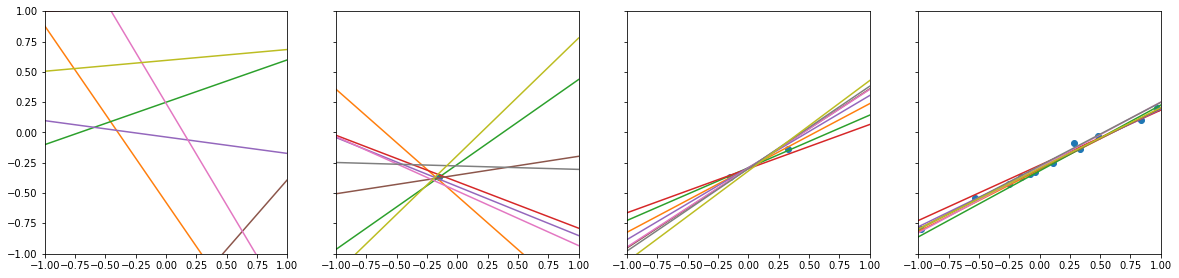

In [64]:
def gen_lin_data(N=100, s=.03):
    '''
    Generates data on the line (t=-0.3+0.5x) with Gaussian noise
    Args:
        N (int): number of samples to generate
        s (float): variance of noise
    Returns:
        X (float ndarray): randomly generated x values
        t (float ndarray): linear target values with Gaussian noise
    '''
    X = (np.random.rand(N, 1)) * 2 - 1
    noise = s * np.random.randn(N, 1) # N(0, .03^2)
    t = -0.3 + 0.5*X + noise
    return X, t

gen_points_num = [0,1,1,10]
alpha = 2
beta = 1/(.2**2)
f, axes = plt.subplots(1, 4, sharey='row', figsize=(20, 5))
for i, ax in zip(range(len(gen_points_num)), axes):
    # Generate random points
    X, t = gen_lin_data(gen_points_num[i])
    
    # Get prior, posterior
    if i == 0:  # default prior
        reg = MAP(X, t, basis_name='none')
        all_X = [*X]
        all_t = [*t]
    else:  # prior is posterior from previous points
        reg = MAP(X, t,
                  m_0=reg.posterior().mean.reshape(-1, 1),
                  S_0=reg.posterior().cov,
                  basis_name='none')
        all_X.extend([*X])
        all_t.extend([*t])

    # Plot points
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set(adjustable='box-forced', aspect='equal')
    ax.plot(all_X, all_t, 'o')

    # Sample 8 weights from posterior
    for _ in range(8):
        w = reg.posterior().rvs()
        x_coords = np.arange(-1, 1.01, .01)
        y_coords = reg.basis_util.dm(x_coords.reshape(-1, 1)).dot(w)
        ax.plot(x_coords, y_coords)
plt.show()

The plots above generate 7 random lines with weights chosen from the posterior. The posterior then becomes the prior and a new posterior is then generated.

## Predictive distribution

Maximizing the above only results in a point estimate. We want to find the entire distribution $p(t|\vec{t},\alpha,\beta)$, where we have omitted the input vector for clarity. <br> We have
$$p(t|\vec{t},\alpha,\beta) = \int{p(t,\vec{w}|\vec{t}, \alpha, \beta)d\vec{w}} = \int{p(t|\vec{w},\beta)p(\vec{w}|\vec{t},\alpha,\beta)}d\vec{w}$$
through marginalizing, using the product rule, and rearranging conditional variables. Recall that
$$p(t|\vec{w},\beta)=\mathcal{N}(t|y(\vec{x},\vec{w}),\beta^{-1})$$ and $$p(\vec{w}|\vec{t},\alpha,\beta)=\mathcal{N}(\vec{m}_n,\mathbf{S}_N)$$
where $\vec{m}_N$ and $\mathbf{S}^{-1}_N$ are given above. By integration, we get
$$p(t|\vec{x},\vec{t},\alpha,\beta)=\mathcal{N}(t|\vec{m}^T_N\vec{\phi}(\vec{x}),\sigma^2_N(\vec{x}))$$
where $\sigma^2_N(\vec{x})=\frac{1}{\beta}+\vec{\phi}(\vec{x})^T\mathbf{S}_N\vec{\phi}(\vec{x})$ (i.e. noise + uncertainty in $\vec{w}$).

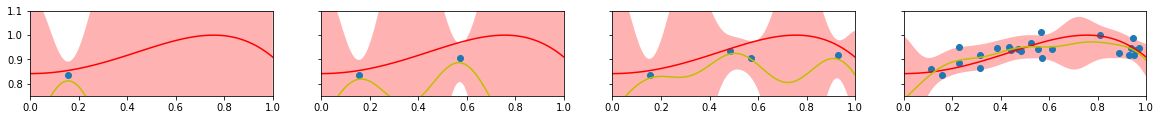

In [69]:
from scipy.stats import norm as sv_gauss


class MAPWithPredDist(MAP):
    def pred_dist(self, x):
        """
        Generates a predictive distribution.
        Args:
            x (float ndarray): value to evaluate predictive distribution at
        Returns:
            pred_dist (sv_gauss): predictive distribution at x
        """
        phi = self.basis_util.dm(x)
        m_N = self.posterior().mean.reshape(-1, 1)
        S_N = self.posterior().cov
        m = m_N.T.dot(phi.T)
        n = 1/self.beta + phi.dot(S_N).dot(phi.T)
        pred_dist = sv_gauss(m.ravel(), n)
        return pred_dist

gen_points_num = [1,1,2,20]
alpha = 2
beta = 1/.2**2

f, axes = plt.subplots(1, 4, sharey='row', figsize=(20, 3))
for i, ax in zip(range(len(gen_points_num)), axes):
    # Generate random points
    X, t = gen_sin(gen_points_num[i])
    m = np.arange(0, 1.01, .1)
    s = .1

    # Get prior, posterior, and MAP estimate
    if i == 0:
        reg = MAPWithPredDist(X, t, alpha=alpha, beta=beta,
                              basis_name='gaussian', m=m, s=s)
        all_X = [*X]
        all_t = [*t]
    else:
        reg = MAPWithPredDist(X, t, alpha=alpha, beta=beta,
                              basis_name='gaussian', m=m, s=s,
                              m_0=reg.posterior().mean.reshape(-1, 1),
                              S_0=reg.posterior().cov)
        all_X.extend([*X])
        all_t.extend([*t])
    reg.fit()

    # Plot points and curve
    ax.set_xlim([0, 1])
    ax.set_ylim([.75, 1.1])
    ax.set(adjustable='box-forced', aspect='equal')
    plot_sin_data(ax, all_X, all_t)
    x_coords = np.arange(0, 1.01, .01)
    y_coords = reg.pred(x_coords.reshape(-1, 1))
    ax.plot(x_coords, y_coords, 'y-')

    # Fill in predictive distribution
    p_low, p_hi = [], []
    x_coords = np.arange(0, 1.01, .01)
    for x in x_coords:
        phi = reg.basis_util.dm(np.asarray([x]))
        p = reg.pred_dist(np.asarray([x]))
        p_low.append(p.mean()-p.std())
        p_hi.append(p.mean()+p.std())
    p_low, p_hi = np.array(p_low).ravel(), np.array(p_hi).ravel()
    ax.fill_between(x_coords, p_low, p_hi, facecolor='red', alpha=0.3)
plt.show()

## Maximizing hyperparameters

Suppose we want to optimize the hyperparameters $\alpha$ and $\beta$. Recall $\alpha$ is the weight precision, and $\beta$ is the noise precision. We will proceed with a process known as "empirical Bayes"/"type 2 maximum likelihood". If we introduce hyperpriors over $\alpha$, $\beta$, the predictive distribution is obtained by marginalizing over $\vec{w}, \alpha, \beta$ so that
$$p(t|\mathbf{t})=\iiint p(t|\vec{w},\beta)\ p(\vec{w}|\mathbf{t},\alpha,\beta)\ p(\alpha,\beta|\mathbf{t})d\vec{w}\ d\alpha \ d\beta$$
where $p(t|\vec{w},\beta)=\mathcal{N}(t|y(\vec{x},\vec{w}),\beta^{-1})$ and $p(\vec{w}|\mathbf{t},\alpha,\beta)=\mathcal{N}(\vec{w}|\vec{m}_N,\mathbf{S}_N)$. If $p(\alpha, \beta|\mathbf{t})$ is sharply peaked around $\hat{\alpha}, \hat{\beta}$, then
$$p(t|\mathbf{t})\simeq p(t|\mathbf{t},\hat{\alpha}, \hat{\beta})=\int p(t|\vec{w},\hat{\beta})p(\vec{w}|\mathbf{t},\hat{\alpha}, \hat{\beta})d\vec{w}$$
Bayes' theorem tells us $p(\alpha, \beta|\mathbf{t})\propto p(\mathbf{t}|\alpha,\beta)p(\alpha,\beta)$, and if we assume $p(\alpha,\beta)$ is relatively flat, then maximizing $p(\mathbf{t}|\alpha,\beta) \Leftrightarrow p(\alpha,\beta|\mathbf{t})$. <br>Hence, we will attempt to maximize the evidence function/marginal likelihood $p(\alpha,\beta|\mathbf{t})$. We know
$$p(\mathbf{t}|\alpha,\beta)=\int p(\mathbf{t}|\vec{w},\beta)p(\vec{w}|\alpha)d\vec{w}$$
where $p(\mathbf{t}|\vec{w},\beta)=\prod_{n=1}^N\mathcal{N}(\vec{t}_n|\vec{w}^T\vec{\phi}(\vec{x}_n),\beta^{-1})$ and $p(\vec{w}|a)=\mathcal{N}(\vec{w}|\vec{0},\alpha^{-1}\mathbf{I}).$<br>
Simplifying, we get $$p(\mathbf{t}|\alpha,\beta)=(\frac{\beta}{2\pi})^{\frac{N}{2}}(\frac{\alpha}{2\pi})^{\frac{M}{2}}\int e^{-E(\vec{w})}d\vec{w}$$
where $M$ is the dimensionality of $\vec{w}$, $N$ is the number of data points, and $E(\vec{w})=\beta E_D(\vec{w})+\alpha E_W(\vec{w})=\frac{\beta}{2}\rVert\mathbf{t}-\Phi\vec{w}\rVert^2+\frac{\alpha}{2}\vec{w}^T\vec{w}$. 
<br>If we complete the square over $\vec{w}$ in $E(\vec{w})$, we get
$$E(\vec{w})=E(\vec{m}_N)+\frac{1}{2}(\vec{w}-\vec{m}_N)^T\mathbf{A}(\vec{w}-\vec{m}_N)$$
where $\mathbf{A}=\alpha\mathbf{I}+\beta\Phi^T\Phi$ (Hessian) and $E(\vec{m}_N)=\frac{\beta}{2}\rVert\mathbf{t}-\Phi\vec{m}_N\rVert^2+\frac{\alpha}{2}\vec{m}_N^T\vec{m}_N$ and $\vec{m}_N=\beta\mathbf{A}^{-1}\Phi^T\mathbf{t}$. Also note that $\mathbf{A}=\mathbf{S}_N^{-1}$. <br> Now we have $\int e^{-E(\vec{w})}d\vec{w}=e^{-E(\vec{m}_N)}\int e^{-\frac{1}{2}(\vec{w}-\vec{m}_N)^T\mathbf{A}(\vec{w}-\vec{m}_N)}d\vec{w}=e^{-E(\vec{m}_N)}(2\pi)^{\frac{M}{2}}|\mathbf{A}|^{-\frac{1}{2}}$, which gives us
$$\log{p(\mathbf{t}|\alpha,\beta)}=\frac{M}{2}\log{\alpha}+\frac{N}{2}\log{\beta}-E(\vec{w}_N)-\frac{1}{2}\log{|\mathbf{A}|}-\frac{N}{2}\log{2\pi}$$
Define eigenvector equation $(\beta\Phi^T\Phi)\vec{\mu}_u=\lambda_i\vec{\mu}_i$ so that $\mathbf{A}$ has eigenvalues $\alpha+\lambda_i$ and $\lambda_i$ are $\beta$ times the eigenvalues of $\Phi^T\Phi$. We have
$$\frac{d}{d\alpha}\log{\mathbf{A}}=\frac{d}{d\alpha}\log{\prod_i(\lambda_i+\alpha)}=\frac{d}{d\alpha}\sum_i\log{(\lambda_i+\alpha)} = \sum_i\frac{1}{\lambda_i+\alpha}$$
$$\frac{d}{d\beta}\log{|\mathbf{A}|}=\frac{d}{d\beta}\log{\prod_i(\lambda_i+\alpha)}=\frac{d}{d\beta}\sum_i\log{(\lambda_i+\alpha)}=\frac{1}{\beta}\sum_i\frac{\lambda_i}{\lambda_i+\alpha}=\frac{\lambda}{\beta}$$
Deriving the log evidence w.r.t. $\alpha$ and w.r.t $\beta$, we get
$$\alpha=\frac{\gamma}{\vec{m}_N^T\vec{m}_N}$$
$$\frac{1}{\beta}=\frac{1}{N-\gamma}\sum_{n=1}^N(t_n-\vec{m}_N^T\vec{\phi}(\vec{x}_n))^2$$
where $\gamma=\sum_i\frac{\lambda_i}{\alpha+\lambda_i}$ and $\vec{m}_N=\beta\mathbf{A}^{-1}\Phi^T\vec{t}$ and $\mathbf{A}=\alpha\mathbf{I}+\beta\Phi^T\Phi$. These are implicit solutions, so we have to iterate by re-estimating $\alpha, \beta$ and calculating $\vec{m}_N, \gamma$.

before:
 [[ 0.80933273]
 [ 0.30867795]
 [ 0.16516266]
 [-0.34065801]]
alpha= 0.436979768408 
beta= 1092.08683505 
gamma= 2.38455480964
after:
 [[ 0.85087651]
 [-0.20409159]
 [ 1.5033173 ]
 [-1.26158352]]


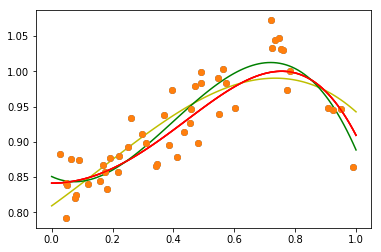

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mv_gauss


class MAPWithType2ML(MAP):
    def _optimize_hyper(self, maxiter=100):
        """
        Optimizes hyperparameters.
        Args:
            maxiter (int): maximum number of iterations to run
        Returns:
            gamma (float): effective number of parameters
        """
        evals, evecs = np.linalg.eig(self.dm.T.dot(self.dm))
        M = self.dm.shape[1]
        for _ in range(maxiter):
            A = self.alpha*np.identity(M)+self.beta*(self.dm.T.dot(self.dm))
            m_N = self.beta*np.linalg.inv(A).dot(self.dm.T).dot(self.t)
            self.gamma = np.sum(evals/(evals + self.alpha))
            self.alpha = self.gamma / np.sum(m_N.T.dot(m_N))
            self.beta = 1/(1/(self.t.shape[0]-self.gamma)*np.sum((self.t - self.dm.dot(m_N))**2))
        return self.gamma
    
# Generate data
X, t = gen_sin(50)
plot_sin_data(plt)

# Initial MAP estimate
alpha = 1
beta = 1/.2**2
reg = MAPWithType2ML(X, t, alpha=alpha, beta=beta)
reg.fit()
print('before:\n', reg.w_map)

#Plot learned curve
x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'y-')
plot_sin_data(plt, X, t)

# Optimize hyperparameters (alpha, beta)
reg._optimize_hyper()
print('alpha=', reg.alpha,'\nbeta=',reg.beta,'\ngamma=', reg.gamma)

# Re-optimize w_map with optimal hyperparameters
reg.fit()
print('after:\n', reg.w_map)

#Plot learned curve
x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt, X, t)

plt.show()


The yellow line shows $w_{map}$ with the initial hyperparameters, and the green line shows $w_{map}$ with optimal hyperparameters. Note that $\gamma$ represents the effective number of parameters.